In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
from cartopy import crs as ccrs

### load the monthly NCEP (NCEP/NCAR) reanalysis temperature (2 m)

see [https://psl.noaa.gov/thredds/catalog/Datasets/catalog.html](https://psl.noaa.gov/thredds/catalog/Datasets/catalog.html)

In [4]:
url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc'

In [5]:
ncep_temp = xr.open_dataset(url)

In [6]:
ncep_temp

<xarray.Dataset>
Dimensions:  (lon: 144, time: 892, lat: 73)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2022-04-01
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                        Model
    Conventions:                     COARDS
    NCO:                             20121012
    history:                         Thu May  4 20:11:16 2000: ncrcat -d time...
    title:                           monthly mean air.sig995 from the NCEP Re...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

In [7]:
ncep_temp = ncep_temp.sel(time=slice(None, '2021'))

In [8]:
levels=np.arange(-40,40+10,10)

In [9]:
levels

array([-40, -30, -20, -10,   0,  10,  20,  30,  40])

In [10]:
ncep_dec_1 =  ncep_temp.sel(time=slice('1950','1959')).mean('time')

ncep_dec_2 = ncep_temp.sel(time=slice('2010','2019')).mean('time')

In [11]:
cbar_kwargs = dict(orientation='horizontal', shrink=0.7, pad=0.05, label='\u00B0C')

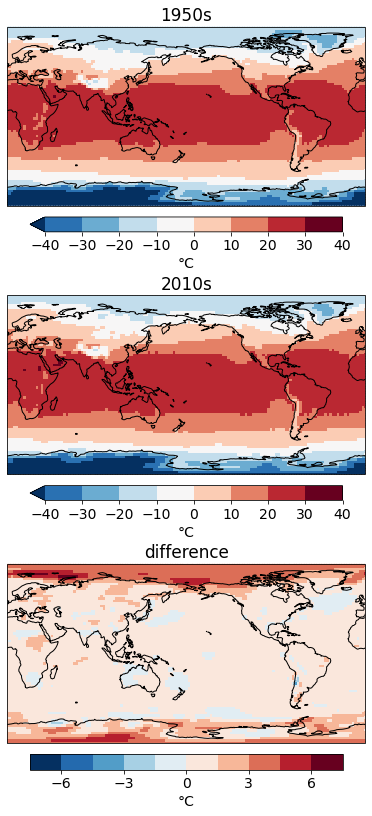

In [12]:
f, axes = plt.subplots(nrows=3, figsize=(8, 14), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

ncep_dec_1['air'].plot(ax=axes[0], transform=ccrs.PlateCarree(), levels=levels, cbar_kwargs=cbar_kwargs)

ncep_dec_2['air'].plot(ax=axes[1], transform=ccrs.PlateCarree(), levels=levels, cbar_kwargs=cbar_kwargs)

(ncep_dec_2 - ncep_dec_1)['air'].plot(ax=axes[2], transform=ccrs.PlateCarree(), levels=10, cbar_kwargs=cbar_kwargs)

[ax.set_title(title) for ax, title in zip(axes, ['1950s','2010s','difference'])]

[ax.coastlines() for ax in axes]; 

In [13]:
cbar_kwargs.update(shrink=0.5)

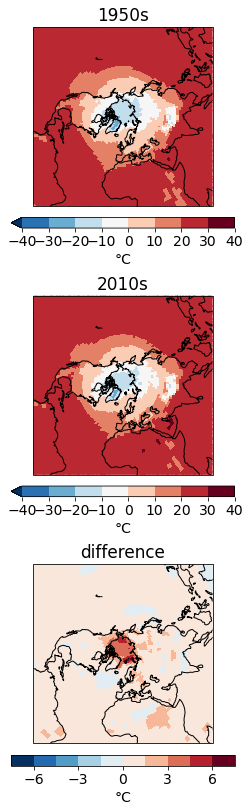

In [14]:
f, axes = plt.subplots(nrows=3, figsize=(8, 14), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=0)))

ncep_dec_1['air'].plot(ax=axes[0], transform=ccrs.PlateCarree(), levels=levels, cbar_kwargs=cbar_kwargs)

ncep_dec_2['air'].plot(ax=axes[1], transform=ccrs.PlateCarree(), levels=levels, cbar_kwargs=cbar_kwargs)

(ncep_dec_2 - ncep_dec_1)['air'].plot(ax=axes[2], transform=ccrs.PlateCarree(), levels=10, cbar_kwargs=cbar_kwargs)

[ax.set_title(title) for ax, title in zip(axes, ['1950s','2010s','difference'])]

[ax.coastlines() for ax in axes]; 

[ax.set_extent([0, 360, 0, 90], crs=ccrs.PlateCarree()) for ax in axes];

In [15]:
Auckland_coordinates = [174.7645, -36.8509]

In [16]:
Auckland = ncep_temp.sel(lon=Auckland_coordinates[0], lat=Auckland_coordinates[1], method='nearest')

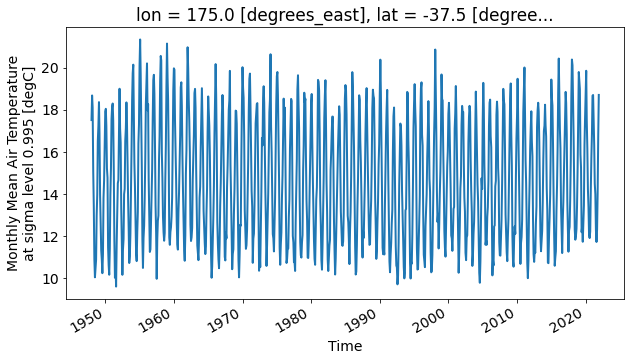

In [17]:
Auckland['air'].plot()

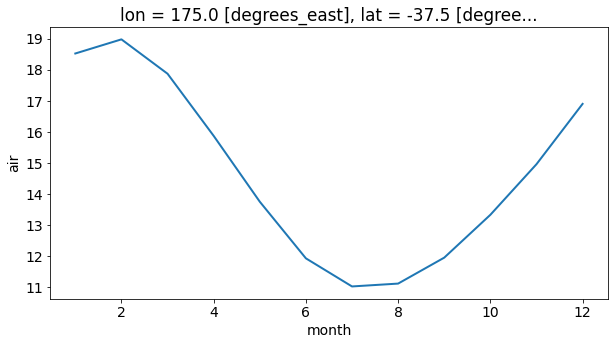

In [18]:
Auckland.groupby(Auckland.time.dt.month).mean('time')['air'].plot()

### we are calculating the anomalies 

#### 1st step: Calculate the climatological 'normal' (now 1991 - 2010)

In [19]:
climatology = ncep_temp.sel(time=slice('1991','2010'))

In [20]:
climatology = climatology.groupby(climatology.time.dt.month).mean('time')

In [21]:
cbar_kwargs = {'shrink':0.7, 'label':'\u00B0C'}

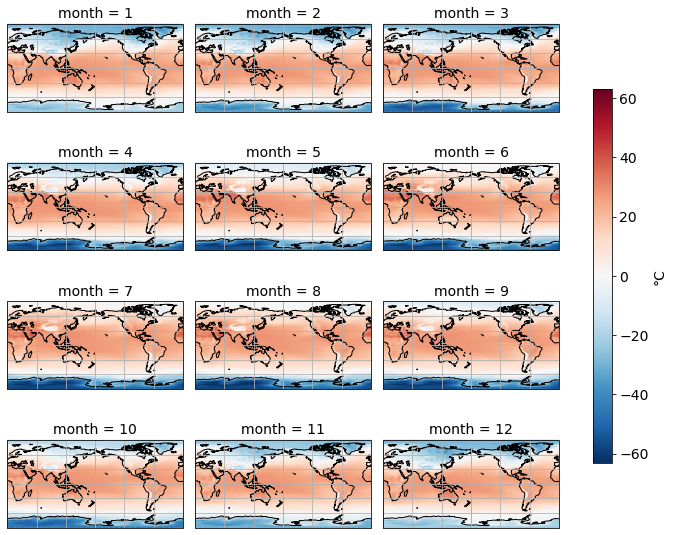

In [22]:
fg = climatology['air'].plot(figsize=(10,8), col='month', col_wrap=3, transform=ccrs.PlateCarree(), \
                            subplot_kws={"projection":ccrs.PlateCarree(central_longitude=180)}, cbar_kwargs=cbar_kwargs)

for ax in fg.axes.flat:
    ax.coastlines()
    ax.gridlines()

#### 2nd step: Remove this climatology from the raw data

In [23]:
ncep_temp_anomalies = ncep_temp.groupby(ncep_temp.time.dt.month) - climatology

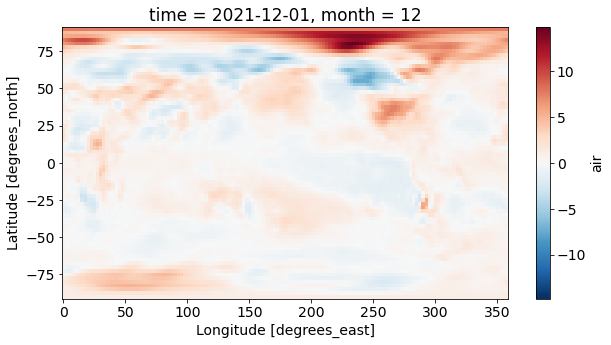

In [24]:
ncep_temp_anomalies.isel(time=-1)['air'].plot()

# Radius and area of earth equations

In [25]:
def earth_radius(lat):
    '''
    calculate radius of Earth assuming oblate spheroid
    defined by WGS84
    
    Input
    ---------
    lat: vector or latitudes in degrees  
    
    Output
    ----------
    r: vector of radius in meters
    
    Notes
    -----------
    WGS84: https://earth-info.nga.mil/GandG/publications/tr8350.2/tr8350.2-a/Chapter%203.pdf
    '''
    from numpy import deg2rad, sin, cos

    # define oblate spheroid from WGS84
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )

    # radius equation
    # see equation 3-107 in WGS84
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )

    return r


def area_grid(lat, lon):
    """
    Calculate the area of each grid cell
    Area is in square meters
    
    Input
    -----------
    lat: vector of latitude in degrees
    lon: vector of longitude in degrees
    
    Output
    -----------
    area: grid-cell area in square-meters with dimensions, [lat,lon]
    
    Notes
    -----------
    Based on the function in
    https://github.com/chadagreene/CDT/blob/master/cdt/cdtarea.m
    """
    from numpy import meshgrid, deg2rad, gradient, cos
    from xarray import DataArray

    xlon, ylat = meshgrid(lon, lat)
    R = earth_radius(ylat)

    dlat = deg2rad(gradient(ylat, axis=0))
    dlon = deg2rad(gradient(xlon, axis=1))

    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))

    area = dy * dx

    xda = DataArray(
        area,
        dims=["lat", "lon"],
        coords={"lat": lat, "lon": lon},
        attrs={
            "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
        },
    )
    return xda

### Area grid

In [26]:
grid_cell_area = area_grid(ncep_temp['lat'].values, ncep_temp['lon'].values)

### Standard mean

In [28]:
standard_mean = ncep_temp_anomalies['air'].mean(['lat','lon'])
standard_mean_smooth = standard_mean.rolling(time=12*5, center=True).mean().dropna("time")

### Weighted mean

In [29]:
total_area_of_earth = grid_cell_area.sum(['lat','lon'])

In [30]:
weighted_mean = ((ncep_temp_anomalies['air'] * grid_cell_area) / total_area_of_earth).sum(['lat','lon'])

In [31]:
weighted_mean_smooth = weighted_mean.rolling(time=12*5, center=True).mean().dropna("time")

Text(0, 0.5, '°C anomaly')

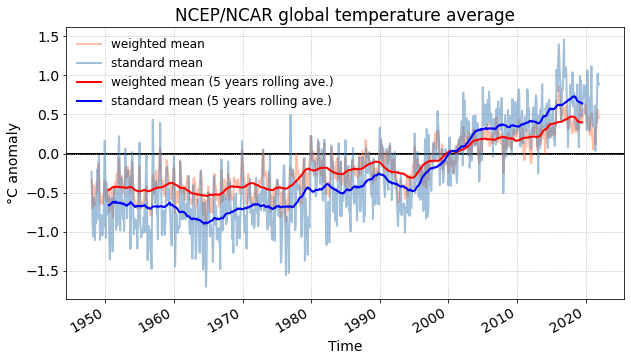

In [32]:
f, ax = plt.subplots()
weighted_mean.plot(ax=ax, label='weighted mean', color='coral', alpha=0.5)
standard_mean.plot(ax=ax, label='standard mean', color='steelblue', alpha=0.5)
weighted_mean_smooth.plot(ax=ax, label='weighted mean (5 years rolling ave.)', color='r')
standard_mean_smooth.plot(ax=ax, label='standard mean (5 years rolling ave.)', color='b')
ax.legend(fontsize=12, frameon=False)
ax.grid(ls=':')
ax.axhline(0, color='k', zorder=0)
ax.set_title('NCEP/NCAR global temperature average')
ax.set_ylabel('\u00B0C' + ' anomaly')

### exporting the time-series in csv 

In [33]:
standard_mean

<xarray.DataArray 'air' (time: 888)>
array([-2.31682435e-01, -6.62670910e-01, -9.23734009e-01, -1.06445408e+00,
       -5.64209461e-01, -8.71726215e-01, -1.10723019e+00, -6.29738748e-01,
       -8.90383065e-01, -4.14383829e-01, -2.02640161e-01, -8.32372725e-01,
       -1.83258057e-01, -2.82037463e-02, -6.98343337e-01, -1.10546434e+00,
       -8.99513900e-01, -7.84624040e-01, -8.47448647e-01, -1.04596281e+00,
       -8.59310687e-01, -9.38584626e-01, -2.29727685e-01,  1.61015987e-01,
       -2.34980807e-01, -1.07755113e+00, -3.66479218e-01, -6.38219297e-01,
       -7.54951119e-01, -7.80211687e-01, -5.44933558e-01, -1.13465381e+00,
       -1.35404408e+00, -1.14436495e+00, -9.30277586e-01, -5.71314991e-01,
       -9.30479944e-01, -1.25340807e+00, -8.28252017e-01, -5.37782967e-01,
       -4.45606619e-01, -6.10112727e-01, -4.66466993e-01, -9.77205575e-01,
       -5.32626808e-01, -9.22221959e-01, -8.04891348e-01, -1.02120088e-02,
        2.21558943e-01, -9.31552127e-02, -9.84972715e-01, -7.12566376e-01,
       -3.08117002e-01, -5.92953205e-01, -6.35473669e-01, -8.33813787e-01,
       -7.31409609e-01, -9.87965286e-01, -4.01437372e-01,  6.45862967e-02,
       -1.63919762e-01, -3.30791235e-01, -8.28590333e-01, -2.48727113e-01,
       -2.12643534e-01, -5.97712278e-01, -3.05513769e-01, -7.22252786e-01,
       -1.21991718e+00, -8.35296571e-01, -1.64301440e-01,  1.91024709e-02,
       -1.89194351e-01, -7.98400879e-01, -1.03039789e+00, -8.40061903e-01,
       -8.38434935e-01, -9.54687595e-01, -9.32444930e-01, -8.51384699e-01,
...
        3.47174197e-01,  1.07287705e+00,  8.32978368e-01,  8.03322256e-01,
        1.22967303e+00,  1.39791000e+00,  1.21124494e+00,  9.53022182e-01,
        8.63949478e-01,  4.04294282e-01,  4.87254232e-01,  8.38428020e-01,
        8.19185257e-01,  1.11012995e+00,  1.45879269e+00,  9.76942718e-01,
        9.84015465e-01,  1.10291195e+00,  1.05840540e+00,  6.88243449e-01,
        6.15477800e-01,  7.62649849e-02,  3.00292164e-01,  3.19719076e-01,
        4.66043323e-01,  8.76022339e-01,  6.74144745e-01,  7.34145403e-01,
        6.48771822e-01,  1.03872406e+00,  6.04224920e-01,  7.83818305e-01,
        7.78040946e-01,  5.31860888e-01,  3.69080067e-01,  5.22004724e-01,
        3.10527802e-01,  8.80904973e-01,  3.13364029e-01,  5.26297867e-01,
        8.13216120e-02,  7.17048705e-01,  9.89059687e-01,  9.19018447e-01,
        9.34975326e-01,  4.70696807e-01,  6.19441688e-01,  7.10886419e-01,
        7.20181644e-01,  8.76169443e-01,  7.25841701e-01,  8.64246964e-01,
        5.05493283e-01,  7.06035733e-01,  3.02692950e-01,  1.06366730e+00,
        8.33306551e-01,  5.89786470e-01,  5.71064591e-01,  2.99109578e-01,
        7.20872760e-01,  6.68757260e-01,  1.11544502e+00,  5.12943983e-01,
        3.68009001e-01,  3.43402922e-01,  4.50712591e-01,  4.08692986e-01,
        6.14191413e-01,  3.39287668e-02,  4.57648396e-01,  3.93759221e-01,
        8.07949483e-01,  1.02281988e+00,  8.72977376e-01,  8.92118633e-01],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [34]:
weighted_mean

<xarray.DataArray (time: 888)>
array([-0.3450703 , -0.5337803 , -0.70695454, -0.61862904, -0.4072949 ,
       -0.49457258, -0.6613778 , -0.4742161 , -0.5118071 , -0.36680683,
       -0.35806167, -0.4622444 , -0.12702611, -0.3070616 , -0.53154427,
       -0.6417213 , -0.5806573 , -0.5775321 , -0.54091656, -0.64342   ,
       -0.5938264 , -0.543576  , -0.43499285, -0.35649002, -0.42877877,
       -0.5859237 , -0.46749783, -0.61572987, -0.5750558 , -0.5636524 ,
       -0.44806334, -0.7503216 , -0.6811104 , -0.6757597 , -0.70112115,
       -0.46607924, -0.59470594, -0.8146226 , -0.6185552 , -0.5376732 ,
       -0.40100986, -0.39992157, -0.36004052, -0.45036578, -0.26216325,
       -0.38820702, -0.31475335, -0.05831522, -0.0855677 , -0.15192768,
       -0.41770074, -0.4332345 , -0.29404145, -0.2852522 , -0.40349543,
       -0.5049956 , -0.422908  , -0.41367018, -0.39500684, -0.2163113 ,
       -0.2176209 , -0.1741308 , -0.3073575 , -0.16552058, -0.24188116,
       -0.23927572, -0.22332223, -0.41595238, -0.49513263, -0.37552655,
       -0.27551907, -0.10011767, -0.31913674, -0.42603156, -0.52292174,
       -0.5883511 , -0.60682094, -0.6694081 , -0.6598464 , -0.6440447 ,
       -0.70293283, -0.604052  , -0.45208123, -0.44061023, -0.16237997,
       -0.57681155, -0.69729257, -0.6999336 , -0.62540567, -0.6581204 ,
       -0.6339805 , -0.59194934, -0.5526035 , -0.47550708, -0.60647   ,
       -0.50860727, -0.4187696 , -0.68085533, -0.69964874, -0.7171049 ,
...
        0.30093008,  0.2009204 ,  0.22218707,  0.00805856,  0.25672722,
        0.29983377,  0.38330644,  0.19873121,  0.222201  ,  0.31582183,
        0.35552704,  0.38586885,  0.2102761 ,  0.27025664,  0.23375712,
        0.28877893,  0.33177713,  0.23854767,  0.34501454,  0.27369976,
        0.24135056,  0.39647615,  0.4855375 ,  0.67153513,  0.6172333 ,
        0.67943823,  0.68716484,  0.8630876 ,  0.82776743,  0.70557606,
        0.5399866 ,  0.43820456,  0.489941  ,  0.51671225,  0.589936  ,
        0.5231688 ,  0.582198  ,  0.4494182 ,  0.5092339 ,  0.5938661 ,
        0.6107211 ,  0.40965253,  0.46941233,  0.31100434,  0.37558237,
        0.4271487 ,  0.43278572,  0.4763259 ,  0.35606238,  0.38547447,
        0.25466686,  0.30236638,  0.37602347,  0.44709724,  0.35544902,
        0.2772016 ,  0.3377121 ,  0.2838445 ,  0.3123282 ,  0.40207443,
        0.27995887,  0.34444165,  0.32086045,  0.41098368,  0.62655115,
        0.56551516,  0.47810277,  0.42253834,  0.44802067,  0.47801587,
        0.53475857,  0.5792097 ,  0.51127017,  0.63176686,  0.57656205,
        0.5787148 ,  0.40206993,  0.4708857 ,  0.4060495 ,  0.2917983 ,
        0.2898049 ,  0.23747306,  0.46527857,  0.38236865,  0.5173206 ,
        0.21080165,  0.18030977,  0.05467831,  0.19746296,  0.23880747,
        0.3264157 ,  0.11773287,  0.291165  ,  0.31852737,  0.5070363 ,
        0.5604958 ,  0.4857106 ,  0.451882  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [35]:
weighted_mean.name = 'weighted mean'

In [36]:
standard_mean.name = 'standard mean'

In [37]:
global_means = xr.merge([weighted_mean, standard_mean])

In [38]:
global_means = global_means.to_pandas()

In [43]:
global_means.head()

,month,weighted mean,standard mean
time,,,
1948-01-01,1,-0.345070,-0.231682
1948-02-01,2,-0.533780,-0.662671
1948-03-01,3,-0.706955,-0.923734
1948-04-01,4,-0.618629,-1.064454
1948-05-01,5,-0.407295,-0.564209


<AxesSubplot:xlabel='time'>

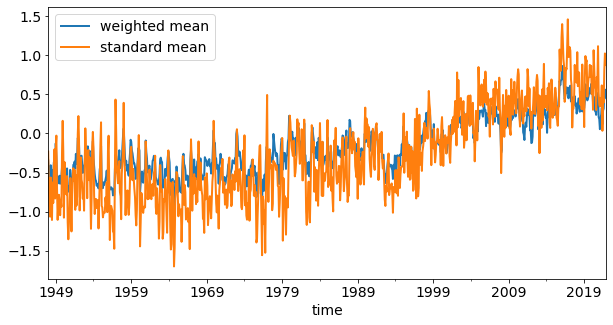

In [39]:
global_means.loc[:,['weighted mean','standard mean']].plot()

In [40]:
global_means.to_csv('../data/NCEP_global_means.csv')

In [41]:
data = pd.read_csv('../data/NCEP_global_means.csv', index_col=0, parse_dates=True)

In [42]:
data.head()

,month,weighted mean,standard mean
time,,,
1948-01-01,1,-0.345070,-0.231682
1948-02-01,2,-0.533780,-0.662671
1948-03-01,3,-0.706955,-0.923734
1948-04-01,4,-0.618629,-1.064454
1948-05-01,5,-0.407295,-0.564209
